# 들어가며

오늘 만들어볼 것은 핸드폰 인물사진 모드입니다. 사실 핸드폰 인물 사진 모드를 정확히 따라히가 위해서는 2개의 렌즈가 필요하지만, 딥러닝을 적용해서 하나의 렌즈만으로 비슷하게 흉내내 보자.

**인물사진 모드에서 사용되는 용어**

배경을 흐리게 하는 기술을 주로 **shallow depth of field 혹은 shallow focus**라고 한다.
 
**학습목표**
- 딥러닝을 적용하여 핸드폰 인물 사진모드를 따라해보자.

**목차**
1. 들어가며
1. 셸로우 포커스 만들기 (1) 사진을 준비하자
1. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기
1. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
1. 셸로우 포커스 만들기 (4) 배경 흐리게 하기
1. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성
1. 프로젝트: 인물 모드 문제점 찾기
1. 프로젝트 제출

# 준비 코드
```
$ mkdir -p ~/aiffel/human_segmentation/models
$ mkdir -p ~/aiffel/human_segmentation/images
```


# 셸로우 포커스 만들기 (1) 사진을 준비하자

## 하나의 카메라로 shallow focus를 만드는 방법

![링크](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-2.max-800x600_jKvxGUl.png)

이렇게 2개의 렌즈의 역할을 하나의 렌즈에서 구현해야 한다. image segmentation 기술을 통해 배경과 사람을 분리할 수 있다. 분리된 배겨을 blur 처리 후 사람이미지와 합치면 된다.


In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


- `urllib`는 웹에서 데이터를 다운로드할 때 사용한다.
- `cv2`는 OpenCV 라이브러리로 이미지를 처리하기 위해 사용한다.
- `pixellib`는 시맨틱 세그멘테이션을 편하게 사용하기 위한 라이브러리이다. 이 모델을 직접 만들기는 어려우니 준비된 모델을 사용하자.

준비한 이미지를 읽어보자.


(960, 960, 3)


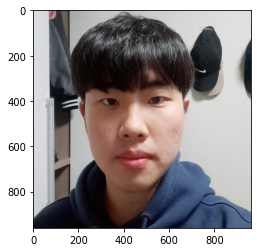

In [253]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

배경에만 렌즈 흐림 효과를 주기 위해 이미지에서 사람과 피사체를 분리해야 하며, 포토샵에서는 '누끼 따기'라고 부른다.

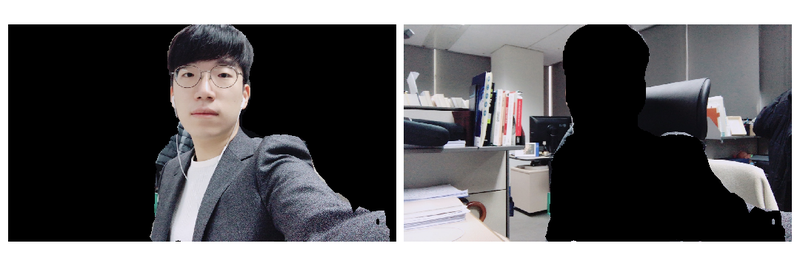

## What is image segmentation?
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 **image segmentation**이라고 한다. 이미지 세그멘테이션은 모든 픽셀에 label을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정한다.

## What is semantic Segmentation?
세그멘테이션 중 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 **semantic segmentataion**이라고 한다.즉, 이미지에서 픽셀을 사람, 차, 비행기 등의 단위로 분류하는 방법이다.

## What is Instance segmentation?
같은 라벨인 경우 같은 특징을 저장하는 대시맨틱 세그멘테이션과 다르게, **instance segmentation**은 개개인별로 다른 라벨을 가지게 한다. 여러 사람이 이미지에 등장할 때 각 객체를 분할해서 인식하는 것이 목표이다.

![MS COCO datasets의 인스턴스 세그멘테이션 라벨 (출처: http://cocodataset.org/#explore)](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-5.max-800x600_YNvIU7P.png)

Q. 인스턴스 세그멘테이션 데이터셋과 라벨이 존재하면 시맨틱 세그멘테이션을 학습시킬 수 있는가?
A. 불가하다. 인스턴스 id뿐만 아니라 클래스 라벨이 존재해야 시맨틱 세그멘테이션으로 학습이 가능하다. 근본적으로는 다른 개념이지만 대부분의 데이터셋은 인스턴스 라벨이 있는 경우 클래스 라벨도 함께 존재한다.


# 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

본격적으로 세그멘테이션을 다루어 보자. 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용되고, 오늘은 그 중에서 DeepLab이라는 세그멘테이션 모델을 이용할 것이다.

오늘은 네트워크 설명보다는 세그멘테이션의 활용 방법 위주로 다룰 것이다..

[DeepLab에 대한 자세한 설명은 여기를 참고](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)

Q. DeepLab에서 atrous convolution을 사용한 이유는?<br>
A: receptive field를 넓게 사용하기 위해 사용합니다. (적은 파라미터로 필터가 더 넓은 영역을 보게 하기 위해)

Q. Depthwise separable convolution은 어디서 처음 사용한 것일까? 왜 이 구조가 효율적일까?<br>
Xception 에서 제안되었습니다. 3x3 conv layer 의 receptive field를 1/9 수준의 파라미터로 구현할 수 있기 때문에 효율적입니다.<br>
[Xception 참고자료](https://arxiv.org/abs/1610.02357)

## 이제 DeepLab모델을 준비하자. 아까 준비한 `PixelLib`를 이용하면 편하게 사용할 수 있다.   
- [PixelLib](https://github.com/ayoolaolafenwa/PixelLib)
에서 제공하는 모델을 다운로드한다.

In [20]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

    # 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f77b0f1b220>)

In [255]:
# 이후 다운로드만 모델을 이용해 `PixelLib`로 우리가 사용한 세그멘테이션 모델을 생성한다.
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [256]:
# 모델에 이미지를 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path)

`segmentAsPascalvoc`라는 함수명에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데, PASCALVOC 데이터로 학습된 모델을 이용하겠다는 의미이다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요하다.

[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

In [257]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있다. 따라서 20의 의미는 tv가 될 것이다! 왜냐하면 0부터 시작하기 때문이다.

우리는 이 중 person라벨, 즉 15를 가진 영역만 검출하자.

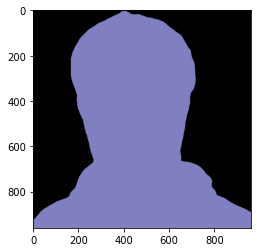

In [258]:
#output

plt.imshow(output)
plt.show()

In [259]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [260]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


output에는 세그멘테이션 결과가 각각 다른 색상으로 담겨있고, segvalues에는 class_ids와 masks가 있다.

이제 물체마다 output에 어떤 색상으로 나타나 있는지를 알아보자.

In [261]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색상을 사용했다고 한다.

In [262]:
# 사람을 나타내는 15번째 색상은 무엇인지 확인하기

colormap[15]

array([192, 128, 128])

주의할 점은 **output 이미지가 BGR순서로 채널 배ㅐ치가 되어 있다는 점이다.** colormap은 RGB 순서이다.

그렇기에 추출해야 하는 색상 값은 순서를 아래처럼 바꿔줘야 한다.

In [263]:
seg_color = (128,128,192)

이제 `seg_color`로만 이뤄진 마스크를 만들어보자.

(960, 960)


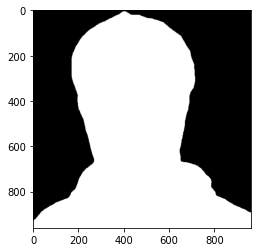

In [264]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

원본과는 다르게 채널 정보가 사라졌다! 물체가 있는 위치는 True, 그렇지 않으면 False인 배열이 되었따.

원래 이미지와 겹쳐서 세그멘테이션이 얼마나 잘 되었는지 살펴보자.

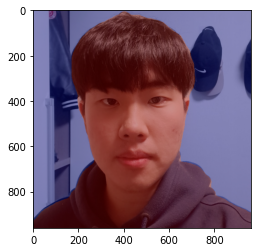

In [265]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 셸로우 포커스 만들기 (4) 배경 흐리게 하기

이제 배경을 흐리게 만들어보자. blur()함수를 이용하면 된다.

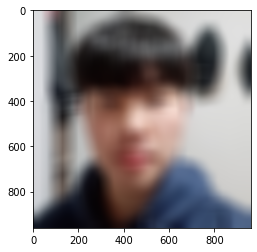

In [266]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (70,70))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

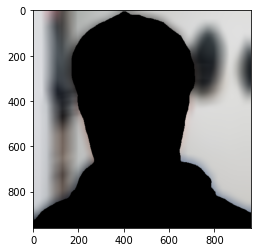

In [267]:
# 흐린 이미지에서 세크멘테이션 마스크를 이용해 배경만 추출하자.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전된다.

반전된 세그멘테이션 결과를 이용해서 `이미지`와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있다.

`0과 어떤 수를 bitwise_and`연산을 해도 0이 되기 때문에, 사람이 0인 경우 사람이 있던 모든 픽셀이 0이 된다.

# 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치자.

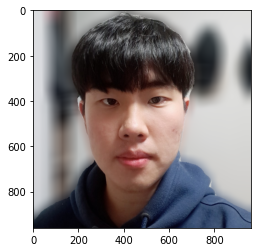

In [268]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트: 인물모드 문제점 찾기

## Step 1. 인물모드 직접 해 보기

1. 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
1. 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
1. 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?


### 1. 인물사진 3장

(2448, 2448, 3)


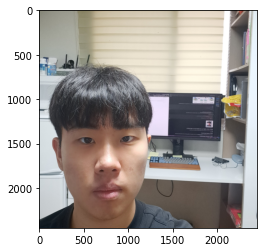

(2448, 2448, 3)


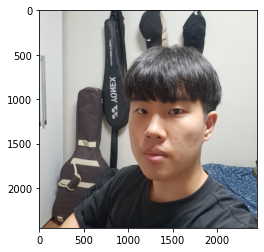

(2448, 2448, 3)


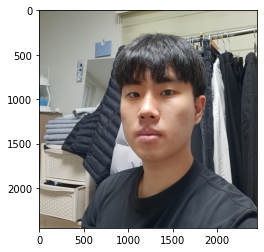

In [269]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_origs = []

for i in range(1,4):

    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image' + str(i) +'.png'  
    img_orig = cv2.imread(img_path) 
    img_origs.append(img_orig)
    
    print(img_orig.shape)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

In [270]:
# 이후 다운로드만 모델을 이용해 `PixelLib`로 우리가 사용한 세그멘테이션 모델을 생성한다.
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [271]:
# 모델에 이미지를 입력하기

img_path_1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image' + str(1) +'.png'  
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image' + str(2) +'.png'  
img_path_3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image' + str(3) +'.png'  


segvalues_1, output_1 = model.segmentAsPascalvoc(img_path_1)
segvalues_2, output_2 = model.segmentAsPascalvoc(img_path_2)
segvalues_3, output_3 = model.segmentAsPascalvoc(img_path_3)


segvalues_list = [segvalues_1,segvalues_2,segvalues_3]
outputs = [output_1, output_2,output_3]

In [272]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

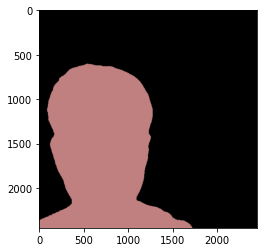

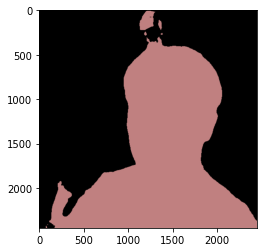

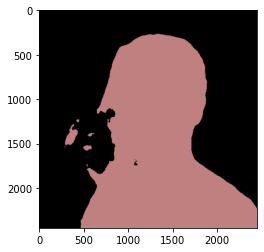

In [273]:
#output
for output in outputs:
    #에러 발생으로 인한 copy
    output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE).copy()
    
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.show()

In [274]:
for i in segvalues_list:
    print(i)

{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])}
{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,


In [275]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [276]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [277]:
# 사람을 나타내는 15번째 색상은 무엇인지 확인하기
#BGR
print(colormap[15]) 

#RGB로 바꾸기!
seg_color = (128,128,192)
print(seg_color)

[192 128 128]
(128, 128, 192)


(2448, 2448)


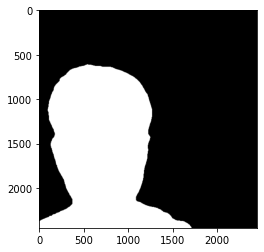

(2448, 2448)


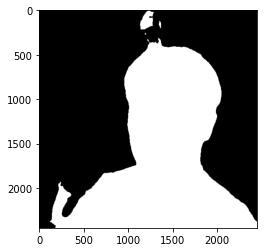

(2448, 2448)


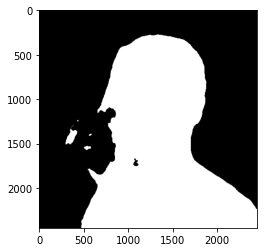

In [278]:
# seg_color 로만 이뤄진 마스크를 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
rotated_outputs = []
seg_maps = []

for output in outputs:
    
    rotated_output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE).copy()
    seg_map = np.all(rotated_output==seg_color, axis=-1)
    
    rotated_outputs.append(rotated_output)
    seg_maps.append(seg_map)
    
    print(seg_map.shape)
    plt.imshow(seg_map, cmap='gray')
    plt.show()

3
3


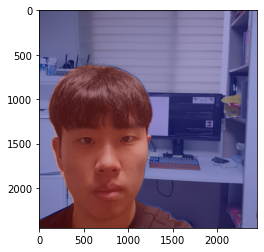

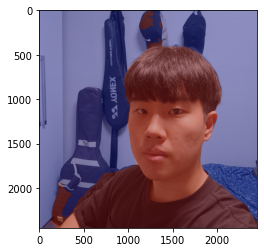

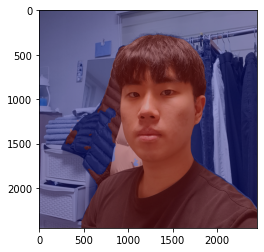

In [279]:
print(len(img_origs))
print(len(seg_maps))

img_masks = []
color_masks = []

for img_orig, seg_map in zip(img_origs, seg_maps):

    # 원 이미지와 겹쳐서 세그멘테이션이 잘 되는지 보기
    img_show = img_orig.copy()

    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    img_masks.append(img_mask)
    
    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    color_masks.append(color_mask)
    
    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

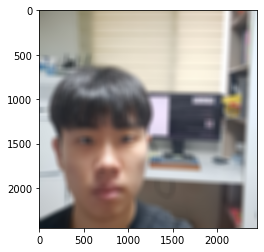

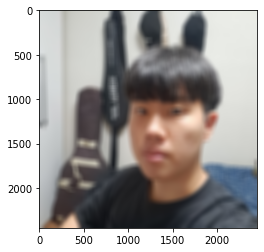

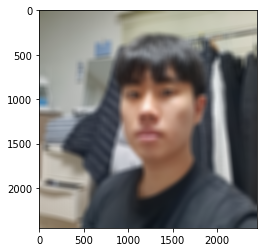

3


In [280]:
# blur 
imgs_orig_blur = []

for img_orig in img_origs:
    img_orig_blur = cv2.blur(img_orig, (70,70))  
    imgs_orig_blur.append(img_orig_blur)
    
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

print(len(imgs_orig_blur))

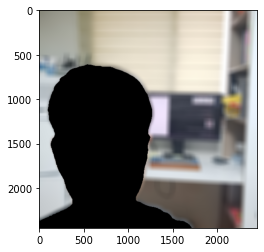

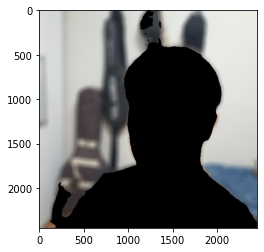

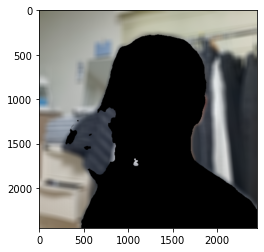

In [281]:
# extract background
img_bg_blurs = []
img_mask_colors = []
for img_orig_blur, img_mask in zip(imgs_orig_blur, img_masks):
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_mask_colors.append(img_mask_color)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    img_bg_blurs.append(img_bg_blur)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()


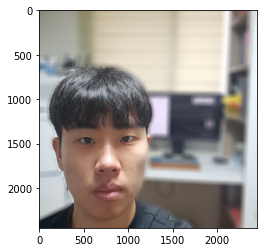

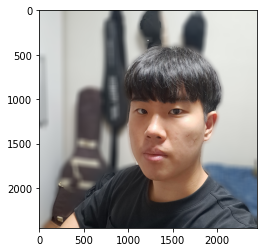

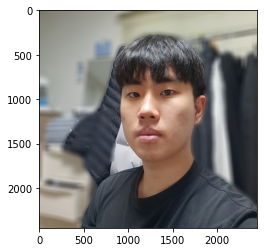

In [282]:
# concat background and human

for img_orig, img_mask_color, img_bg_blur in zip(img_origs, img_mask_colors, img_bg_blurs):

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

### 2. 고양이 아웃포커싱

(371, 660, 3)


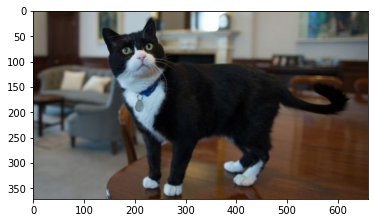

In [283]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_cat = cv2.imread(img_path) 

print(img_cat.shape)
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [284]:
# 이후 다운로드만 모델을 이용해 `PixelLib`로 우리가 사용한 세그멘테이션 모델을 생성한다.
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [285]:
# 모델에 이미지를 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path)

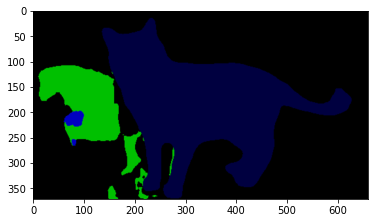

In [286]:
#output

plt.imshow(output)
plt.show()

In [287]:
seg_color = (0, 0, 64)

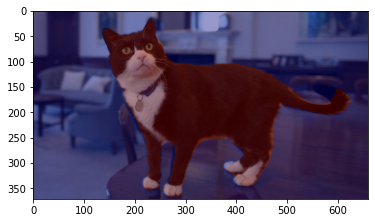

In [309]:
img_show = img_cat.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

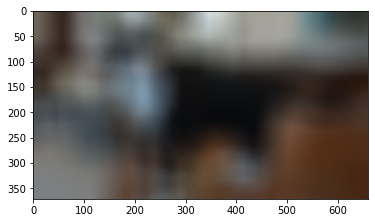

In [310]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_cat, (70,70))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

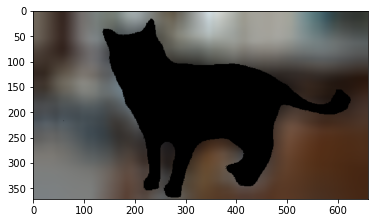

In [311]:
# 흐린 이미지에서 세크멘테이션 마스크를 이용해 배경만 추출하자.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

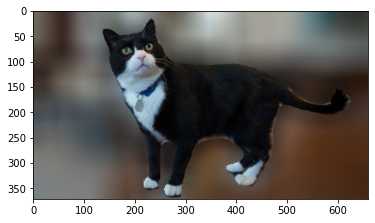

In [312]:
img_concat = np.where(img_mask_color==255, img_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 3. 크로마키 배경 합성

(371, 660, 3)


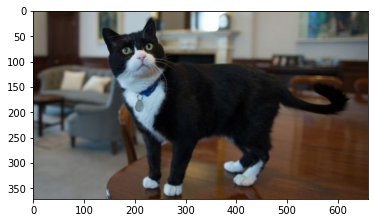

In [295]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_cat = cv2.imread(img_path) 

print(img_cat.shape)
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [296]:
# 이후 다운로드만 모델을 이용해 `PixelLib`로 우리가 사용한 세그멘테이션 모델을 생성한다.
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [297]:
# 모델에 이미지를 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path)

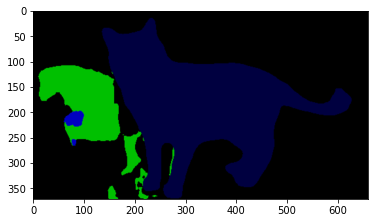

In [298]:
#output

plt.imshow(output)
plt.show()

In [299]:
segvalues

{'class_ids': array([ 0,  8,  9, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [300]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
chair
sofa


In [301]:
colormap[8]

array([64,  0,  0])

In [302]:
seg_color = (0, 0, 64)

(371, 660)


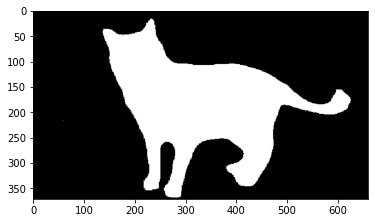

In [303]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

(371, 660, 3)


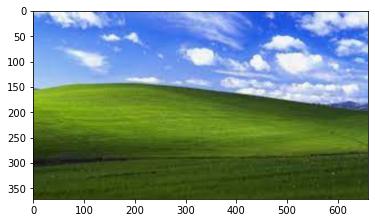

In [304]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.png'  
img_orig = cv2.imread(img_path) 
img_orig = cv2.resize(img_orig, dsize=(660,371))

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


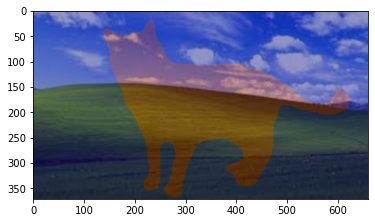

In [305]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

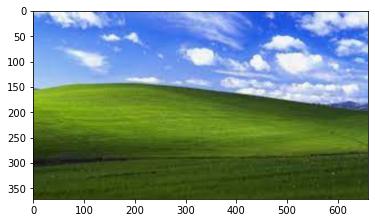

In [306]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (1,1))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

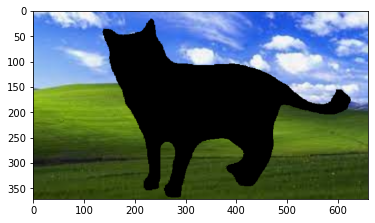

In [307]:
# 흐린 이미지에서 세크멘테이션 마스크를 이용해 배경만 추출하자.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


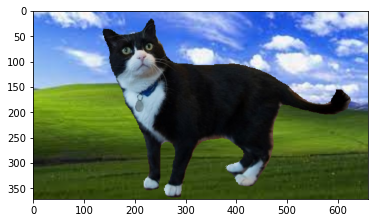

In [308]:
img_concat = np.where(img_mask_color==255, img_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전된다.

반전된 세그멘테이션 결과를 이용해서 `이미지`와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있다.

`0과 어떤 수를 bitwise_and`연산을 해도 0이 되기 때문에, 사람이 0인 경우 사람이 있던 모든 픽셀이 0이 된다.

## step2. 사진에서 문제점 찾기

그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

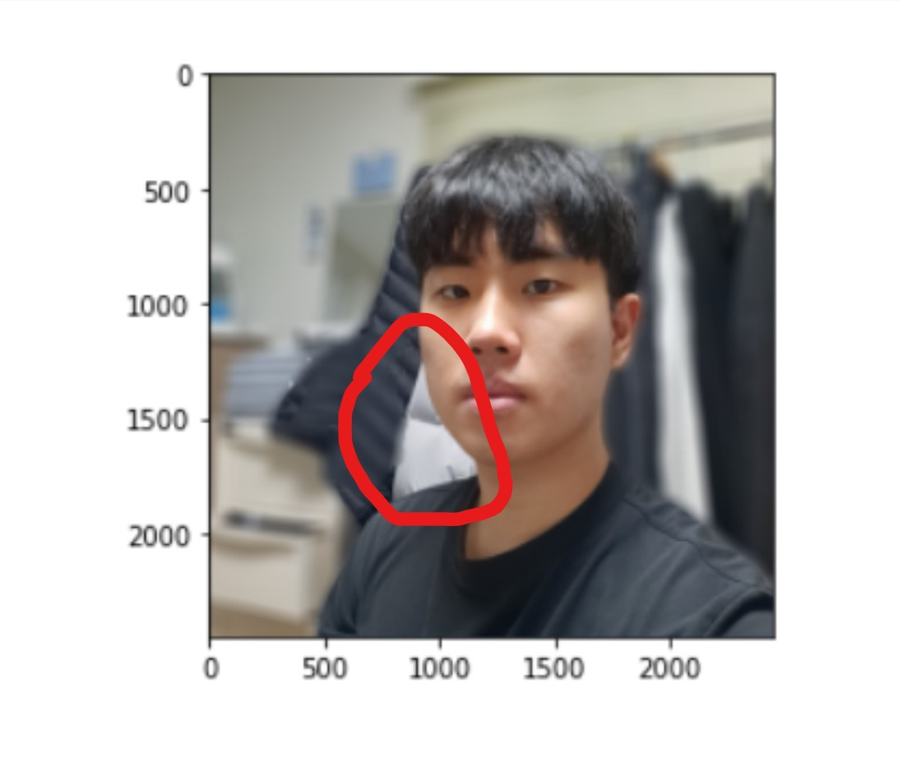



예시에서의 패딩과 같이, 어깨와 볼 사이에 이미지가 있는 경우, 인식이 잘 되지 않았다.

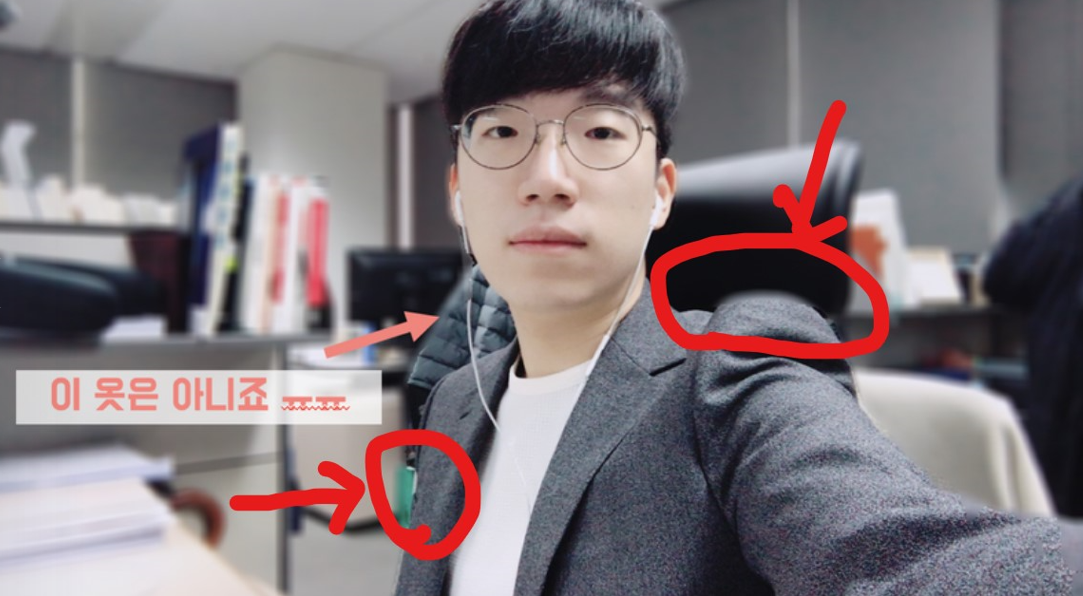

또한, 왼쪽 어깨 부분과 같은 곳에서 인식이 조금 부족하여 흐리게 나옴이 보인다. 

반면에 오른쪽 어깨의 경우 범위보다 더욱 인식하여, blur 처리돼야 할 곳이 처리되지 않았다.

## step3. 해결방법을 제안해 보기

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러 문제를 발생시키는 주원인이다. 피사계심도를 이용한 보케 효과는 말그대로 심도를 표현하기 때문에, 초점이 잡힌 거리를 아주 섬세하게 구별하낟.

### 피사계 심도 이해하기
[아웃포커싱 하는 법](https://m.blog.naver.com/typs6301/222172333739)

[얕은 피사계 심도 촬영의 이해](https://www.adobe.com/kr/creativecloud/photography/discover/shallow-depth-of-field.html)

### 3D 카메라 활용하기
크게는 스테레오 비전, ToF방식 등이 사용된다. 하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전하였다.

[참고 자료(최신기술)-3D 이미지센서]

### 소프트웨어 기술 활용하기
ex. 구글의 struct2Depth

- [Unsupervised Learning of Depth and Ego-Motion: A Structured Approach](https://sites.google.com/view/struct2depth)

### 다른 기술과 융합해 보기
구글 pixel4에는 IR카메라가 있어, 물체의 온도를 측정하여 더욱 좋은 3d depth sensing이 가능하게 한다.

- [uDepth: Real-time 3D Depth Sensing on the Pixel 4](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)

이렇게 카메라와 무관한 기술과 융합해도 좋을 것이다!

**가능하다면 순서도(Flow Chart)를 활용하면 좋을 것이다.**

[참고](https://pixellib.readthedocs.io/en/latest/image_ade20k.html)

(2448, 2448, 3)


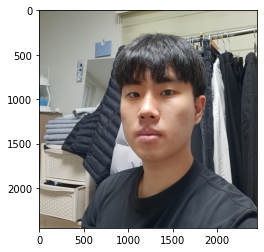

In [192]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [24]:
import pixellib
from pixellib.semantic import semantic_segmentation

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception65_ade20k.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.3/deeplabv3_xception65_ade20k.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)


('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception65_ade20k.h5',
 <http.client.HTTPMessage at 0x7f77b13b14f0>)

In [193]:
# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception65_ade20k.h5')

#created an instance of semantic segmentation class
segment_image = semantic_segmentation()
segment_image.load_ade20k_model(model_file)
segvalues, output_image = segment_image.segmentAsAde20k(img_path)

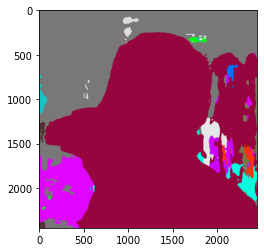

In [194]:
# rotate, 출력
output_image = cv2.rotate(output_image, cv2.ROTATE_90_CLOCKWISE).copy()
    
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.show()

In [195]:
segvalues

{'class_ids': [13, 1, 11, 32, 9, 8, 6, 19, 28, 148, 4, 93, 99, 42, 82],
 'class_names': ['person',
  'wall',
  'cabinet',
  'seat',
  'windowpane',
  'bed',
  'ceiling',
  'curtain',
  'mirror',
  'glass',
  'floor',
  'apparel',
  'bottle',
  'box',
  'towel'],
 'class_colors': [array([150,   5,  61]),
  array([120, 120, 120]),
  array([224,   5, 255]),
  array([  7, 255, 224]),
  array([230, 230, 230]),
  array([204,   5, 255]),
  array([120, 120,  80]),
  array([255,  51,   7]),
  array([220, 220, 220]),
  array([ 25, 194, 194]),
  array([80, 50, 50]),
  array([  0, 112, 255]),
  array([  0, 255,  10]),
  array([  0, 255,  20]),
  array([255,   0, 102])],
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, Fal

In [196]:
# ids 확인
for ids, names, colors in (zip(segvalues['class_ids'] , segvalues['class_names'], segvalues['class_colors'])):
    print(ids, names, colors)

13 person [150   5  61]
1 wall [120 120 120]
11 cabinet [224   5 255]
32 seat [  7 255 224]
9 windowpane [230 230 230]
8 bed [204   5 255]
6 ceiling [120 120  80]
19 curtain [255  51   7]
28 mirror [220 220 220]
148 glass [ 25 194 194]
4 floor [80 50 50]
93 apparel [  0 112 255]
99 bottle [  0 255  10]
42 box [  0 255  20]
82 towel [255   0 102]


In [197]:
# seg_color 바꾸기
seg_colors = []

for class_color in segvalues['class_colors']:
    seg_colors.append(np.flip(class_color))

In [198]:
seg_colors

[array([ 61,   5, 150]),
 array([120, 120, 120]),
 array([255,   5, 224]),
 array([224, 255,   7]),
 array([230, 230, 230]),
 array([255,   5, 204]),
 array([ 80, 120, 120]),
 array([  7,  51, 255]),
 array([220, 220, 220]),
 array([194, 194,  25]),
 array([50, 50, 80]),
 array([255, 112,   0]),
 array([ 10, 255,   0]),
 array([ 20, 255,   0]),
 array([102,   0, 255])]

(2448, 2448)


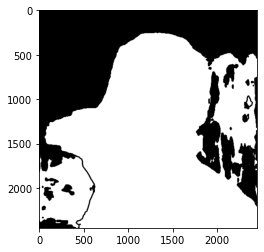

In [199]:
seg_color_0 = seg_colors[0] #person
seg_color_1 = seg_colors[2] #cabinet


seg_map0 = np.all(output_image==seg_color_0, axis=-1)
seg_map1 = np.all(output_image==seg_color_1, axis=-1)


seg_map = seg_map0 + seg_map1 

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

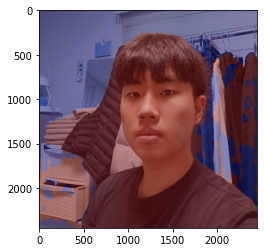

In [200]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

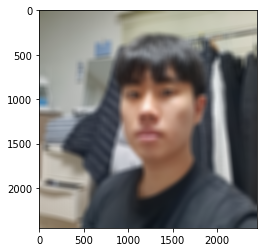

In [201]:
#blur
img_orig_blur = cv2.blur(img_orig, (70,70))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

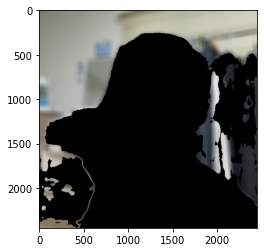

In [202]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

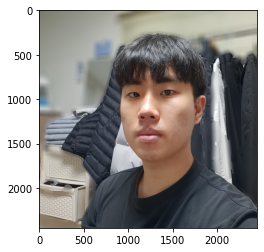

In [203]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

1. 이번 프로젝트에서 어려웠던 점   
- image segmentation을 하고 난 후 image가 자동으로 rotate되는데, 그 이유를 찾지 못했다.

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.   
- 아직 1번 문제를 해결하지 못했다.

3. 루브릭 평가 지표를 맞추기 위해 시도한 것들   
- 이미지에서 발생한 문제점을 살펴보고, 표시했다
- semantic segmentation을 Ade20k model을 통해서 분석해보았다.

4. 자기다짐
- 공부가 잘 돼 가고 있는지 모르겠다. 공부법에 대해 다시 생각해보자.
- 내가 이걸 잘 이해하고 사용하는 건지, 따라하기만 하고 있는 건 아닌지//
   - 따라하기만 한다면, 왜 그런지, 왜 잘 이해하고 있지 못하는지?   